In [ ]:
# Package imports
import pandas as pd
import numpy as np
import seaborn as sns

# Display matplotlib graphs in notebook
from matplotlib import pyplot as plt
%matplotlib inline

# Set all Figure Size to 12,8
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

# Import Date Time for Time Series
from datetime import datetime

# Pandas Display Options
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 150

# Increase display width
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Return Pandas Dataframes instead of Numpy Arrays
from sklearn import set_config
set_config(transform_output="pandas")

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Show progrss bar during code compilation
from tqdm import tqdm

In [ ]:
# Analysis is for one year of BTC price data: 2-6-2023 to 2-8-2024.
  # We pull data starting from January so that 1-day/5-day/25-day fractal time frame analysis is possible on February 2023 data.

import yfinance as yf

df = yf.download('BTC-USD', start = '2023-1-14', end = '2024-2-11', progress = False)

In [ ]:
# Confirm Index is of type DatetimeIndex.

df.index

DatetimeIndex(['2023-01-14', '2023-01-15', '2023-01-16', '2023-01-17',
               '2023-01-18', '2023-01-19', '2023-01-20', '2023-01-21',
               '2023-01-22', '2023-01-23',
               ...
               '2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10'],
              dtype='datetime64[ns]', name='Date', length=393, freq=None)

In [ ]:
# Confirm dataframe was constructed with expected data.

df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-14,19910.54,21075.14,19907.83,20976.30,20976.30,38967784639
2023-01-15,20977.48,20993.75,20606.99,20880.80,20880.80,19298407543
2023-01-16,20882.22,21360.88,20715.75,21169.63,21169.63,26792494050
2023-01-17,21175.83,21438.66,20978.53,21161.52,21161.52,24999983362
2023-01-18,21161.05,21564.50,20541.54,20688.78,20688.78,30005625418


In [ ]:
# Remove all columns except the closing price

df = df[['Close']]

In [ ]:
# Rename feature to Price

df = df.rename({'Close': 'Price'}, axis = 1)

In [ ]:
# Confirm we do not have null data in our Time Series

df.isnull().sum()

Price    0
dtype: int64

In [ ]:
# We will need the row number in integer form later on.

df['idx_num'] = np.arange(df.shape[0])

In [ ]:
# Confirmation Time Series is properly formatted and cleaned prior to Linear Regression.

df.head()

,Price,idx_num
Date,,
2023-01-14,20976.30,0
2023-01-15,20880.80,1
2023-01-16,21169.63,2
2023-01-17,21161.52,3
2023-01-18,20688.78,4


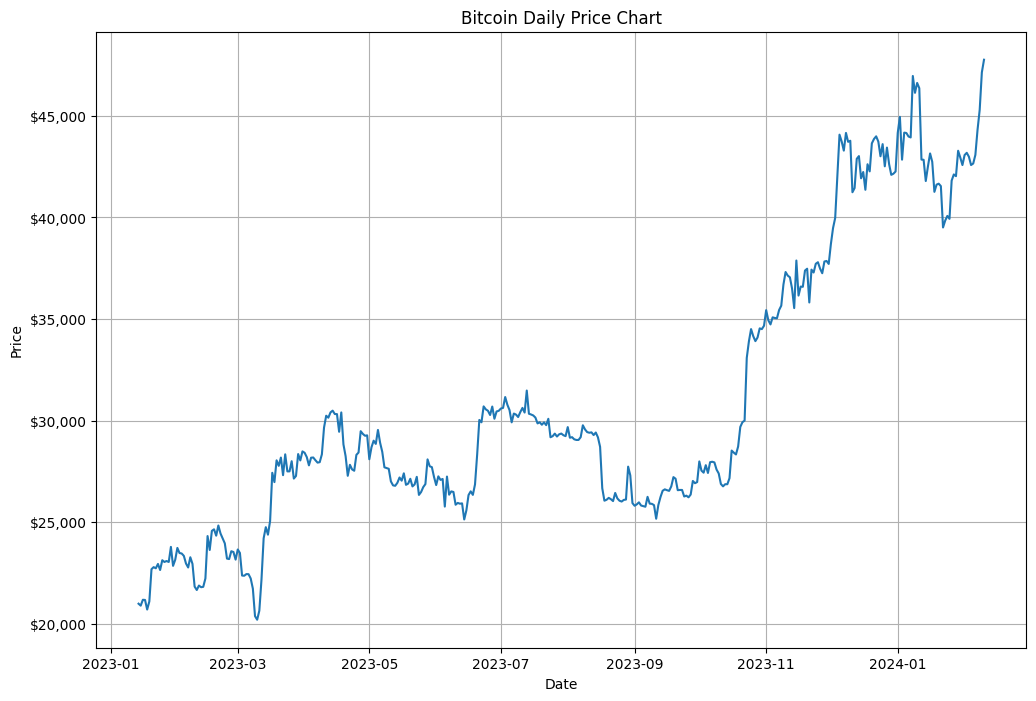

In [ ]:
# Plot Bitcoin Daily Price Data

import matplotlib.ticker as mtick
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

fig, ax = plt.subplots(1, 1)
plt.plot(df.Price)
plt.title('Bitcoin Daily Price Chart')
plt.xlabel('Date')
plt.ylabel('Price')
ax.yaxis.set_major_formatter(tick)
plt.yticks
plt.grid(True)

In [ ]:
# Determine the week day based upon the datetime index
import calendar

calendar.day_name[df.index[0].weekday()]

'Saturday'

In [ ]:
# Determine all Monday and Thursday dates in Time Series, and add to respective list.
  # Our trades execute on Tuesday 12:00 am using the closing price from Monday.
  # Our trades close on Friday 12:00 am using the closing price from Thursday.
  # The prices for Monday - Thursday serve as our test data for the regression

# Build list of current price + n days of lag prices, and add price list to respective list.
  # Lag prices serve as the training data for the regression.

# Build list of linear regressions and add slopes to respective list.

Monday = []
Thursday = []
Future_Price_3_Day = []

Lag_Price_1_Day = []
Lag_Price_5_Day = []
Lag_Price_25_Day = []

Slopes_1_Day = []
Slopes_5_Day = []
Slopes_25_Day = []

In [ ]:
# Monday and Thursday list.

for index, values in df.iterrows():
  if calendar.day_name[index.weekday()] == 'Monday':
    Monday.append(index)
  elif calendar.day_name[index.weekday()] == 'Thursday':
    Thursday.append(index)

In [ ]:
# Slice list to remove date values prior to Feb 6 2023.
  # We need price data in January to calculate slope of 25 day fractal timeframe.
  # But we don't want active trades to go this far back. Active trades start Monday Feb 6 2023.

Monday = Monday[3:]
Thursday = Thursday[3:]

In [ ]:
Monday[0]

Timestamp('2023-02-06 00:00:00')

In [ ]:
Thursday[0]

Timestamp('2023-02-09 00:00:00')

In [ ]:
# Function to populate lag price list.

def build_lags(Monday_list, days, lag_list):
  for list_idx, timestamp in enumerate(Monday_list):
    for df_idx, price, row_idx in df.itertuples():
      if timestamp == df_idx:
        temp_list = []
        for x in range(row_idx - days, row_idx):
          temp_list.append(df.loc[df.index[x]]['Price'])
        lag_list.append(temp_list)

In [ ]:
# Build the lag lists for each fractal timeframe.
  # Need 2 data points to do a linear regression.
  # Lag_Price_1_Day is only lag list with this "= 1".

build_lags(Monday, 2, Lag_Price_1_Day)
build_lags(Monday, 5, Lag_Price_5_Day)
build_lags(Monday, 25, Lag_Price_25_Day)

In [ ]:
Lag_Price_1_Day

[[23331.84765625, 22955.666015625],
 [21870.875, 21788.203125],
 [24641.27734375, 24327.642578125],
 [23175.375, 23561.212890625],
 [22353.349609375, 22435.513671875],
 [20632.41015625, 22163.94921875],
 [26965.87890625, 28038.67578125],
 [27494.70703125, 27994.330078125],
 [28411.03515625, 28199.30859375],
 [27947.794921875, 28333.05078125],
 [30318.49609375, 30315.35546875],
 [27817.5, 27591.384765625],
 [29248.48828125, 29268.806640625],
 [28904.623046875, 28454.978515625],
 [26784.078125, 26930.638671875],
 [27129.5859375, 26753.826171875],
 [26868.353515625, 28085.646484375],
 [27075.12890625, 27119.06640625],
 [25851.240234375, 25940.16796875],
 [26510.67578125, 26336.212890625],
 [30548.6953125, 30480.26171875],
 [30590.078125, 30620.76953125],
 [30292.541015625, 30171.234375],
 [30295.806640625, 30249.1328125],
 [29771.802734375, 30084.5390625],
 [29356.91796875, 29275.30859375],
 [29042.126953125, 29041.85546875],
 [29415.96484375, 29282.9140625],
 [26096.205078125, 26189.5839

In [ ]:
# Build generic x value to calculate the slope of price (y value).

X_Lag_1 = [i for i in range(len(Lag_Price_1_Day[0]))]
X_Lag_5 = [i for i in range(len(Lag_Price_5_Day[0]))]
X_Lag_25 = [i for i in range(len(Lag_Price_25_Day[0]))]

In [ ]:
X_Lag_5

[0, 1, 2, 3, 4]

In [ ]:
from scipy.stats import linregress

In [ ]:
# Function to build slope list.

def build_slopes(Monday_list, lag_list, x_lag_list, slope_list):
  for list_idx, timestamp in enumerate(Monday_list):
    temp_list = []
    slope = linregress(lag_list[list_idx], x_lag_list).slope
    temp_list.append(slope)
    slope_list.append(temp_list)

In [ ]:
# Build the slopes for each fractal timeframe.

build_slopes(Monday, Lag_Price_1_Day, X_Lag_1, Slopes_1_Day)
build_slopes(Monday, Lag_Price_5_Day, X_Lag_5, Slopes_5_Day)
build_slopes(Monday, Lag_Price_25_Day, X_Lag_25, Slopes_25_Day)

In [ ]:
Slopes_5_Day

[[-0.005345286332218854],
 [-0.002050663334427405],
 [0.0016386415841802772],
 [-0.002503583167610437],
 [-0.002107715135613876],
 [0.0003780921896512336],
 [0.0009274184065052068],
 [0.0007378065337010541],
 [0.0006212823215901354],
 [0.0018431065521071026],
 [0.004133750829042764],
 [-0.0019960688273176607],
 [0.0021142762526776917],
 [-0.001736419760449349],
 [-0.0033876253823570328],
 [-0.0035877237930278163],
 [0.002008775266041445],
 [0.0004651306982816101],
 [-0.0038557610552763],
 [0.0023583709068308576],
 [0.003281215612725311],
 [0.006680770884695192],
 [-0.0014962629711114013],
 [-0.001351223689910813],
 [0.005156721907073357],
 [-0.0008641256961270259],
 [-0.021932770016929833],
 [-0.014491505986293288],
 [-0.001107820953904799],
 [-0.0073753419187951],
 [-0.0017043133062327129],
 [-0.0013449833843705286],
 [0.006889738608266087],
 [-0.004346233342228463],
 [0.0023170100637711607],
 [0.003835750104252091],
 [0.007406672733420793],
 [0.0019804569689130832],
 [1.4307663171386

In [ ]:
Slopes_All_Fractal_Timeframes = []

In [ ]:
# Create a list of all three slopes per timestamp.
  # Add this list to list slopes all fractal timeframes.
  # Allows us to view each fractal slope per timestamp.

for list_idx, timestamp in enumerate(Monday):
  temp_list = []
  temp_list.append(Slopes_1_Day[list_idx])
  temp_list.append(Slopes_5_Day[list_idx])
  temp_list.append(Slopes_25_Day[list_idx])
  Slopes_All_Fractal_Timeframes.append(temp_list)

In [ ]:
Slopes_All_Fractal_Timeframes

[[[-0.0026582902832221387],
  [-0.005345286332218854],
  [-0.00038443532668467093]],
 [[-0.012096012096012096], [-0.002050663334427405], [-0.0014244526662616477]],
 [[-0.003188422042458323], [0.0016386415841802772], [0.0010031729997779834]],
 [[0.0025917620438473494], [-0.002503583167610437], [0.003176611157075314]],
 [[0.01217077113245222], [-0.002107715135613876], [0.001555441993817395]],
 [[0.0006529379657921718], [0.0003780921896512336], [-0.0049815235091567505]],
 [[0.0009321429091597606], [0.0009274184065052068], [0.0015187985812070122]],
 [[0.0020015089501069167], [0.0007378065337010541], [0.0022087577282362144]],
 [[-0.004723072949337663], [0.0006212823215901354], [0.0022655880204813733]],
 [[0.0025956775884532907], [0.0018431065521071026], [0.005657241477773397]],
 [[-0.31840796019900497], [0.004133750829042764], [0.005507738739708922]],
 [[-0.004422523775384163], [-0.0019960688273176607], [0.0014755280506968938]],
 [[0.049216572142651155], [0.0021142762526776917], [-0.0008932

In [ ]:
# A List of all profits and losses for every week's trade.

Trade_Profit_Loss = []

for list_idx, timestamp in enumerate(Monday):
  temp_list = []
  buy = df.loc[Monday[list_idx]]['Price']
  sell = df.loc[Thursday[list_idx]]['Price']
  delta = sell - buy
  temp_list.append(delta)
  Trade_Profit_Loss.append(temp_list)

In [ ]:
Trade_Profit_Loss

[[-941.0703125],
 [1815.373046875],
 [-881.65625],
 [-47.404296875],
 [-2066.736328125],
 [855.255859375],
 [566.736328125],
 [893.673828125],
 [253.919921875],
 [746.0859375],
 [-1199.056640625],
 [1948.447265625],
 [756.142578125],
 [-693.484375],
 [-360.484375],
 [-375.0703125],
 [-925.912109375],
 [748.119140625],
 [-326.10546875],
 [3061.251953125],
 [174.220703125],
 [-1247.1015625],
 [1061.578125],
 [-353.873046875],
 [33.7734375],
 [-51.431640625],
 [249.013671875],
 [-2743.892578125],
 [38.232421875],
 [-174.677734375],
 [427.779296875],
 [1377.01953125],
 [-186.6484375],
 [723.06640625],
 [-114.873046875],
 [-826.87890625],
 [200.33984375],
 [1070.4140625],
 [435.87890625],
 [1655.75390625],
 [-347.5859375],
 [-187.3359375],
 [458.578125],
 [1312.56640625],
 [1780.140625],
 [1245.61328125],
 [-985.28515625],
 [12.58984375],
 [-601.91796875],
 [-1249.91015625],
 [426.44140625],
 [-212.47265625],
 [2642.8984375]]

In [ ]:
# List value will determine if we have a signal to enter a trade long.
  # If 'Buy', then 2 of the 3 adjacent slopes had positive slope.
  # Otherwise, "Wait".

Trade_Indicator = []

for list_idx, timestamp in enumerate(Monday):
  temp_list = []
  slopes = Slopes_All_Fractal_Timeframes[list_idx]

  if slopes[1][0] <= 0:
    temp_list.append("Wait")
  elif slopes[0][0] > 0:
    temp_list.append("Buy")
  elif slopes[2][0] > 0:
    temp_list.append("Buy")
  else:
    temp_list.append("Wait")

  Trade_Indicator.append(temp_list)

In [ ]:
Trade_Indicator

[['Wait'],
 ['Wait'],
 ['Buy'],
 ['Wait'],
 ['Wait'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Wait'],
 ['Buy'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Buy'],
 ['Buy'],
 ['Wait'],
 ['Wait'],
 ['Buy'],
 ['Buy'],
 ['Wait'],
 ['Wait'],
 ['Buy'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Wait'],
 ['Buy'],
 ['Wait'],
 ['Buy'],
 ['Buy'],
 ['Buy'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Buy'],
 ['Wait'],
 ['Wait'],
 ['Wait'],
 ['Wait']]

In [ ]:
# Create Control and Experiment Trading Accounts
  # Starting Balance $100k.
  # Every trade profit/loss will go against this account.

control_account = 100000.00
experiment_account = 100000.00

In [ ]:
# Control Account trades every week.
  # Iterate through entire Trade_Profit_Loss list.

for list_idx, timestamp in enumerate(Monday):
  delta = Trade_Profit_Loss[list_idx]
  control_account += delta[0]

In [ ]:
# Experimental Account trades only when indicator shows "Buy".
  # Iterates through some of Trade_Profit_Loss list.

for list_idx, timestamp in enumerate(Monday):
  if Trade_Indicator[list_idx][0] == 'Buy':
    delta = Trade_Profit_Loss[list_idx]
    experiment_account += delta[0]

In [ ]:
control_account

109870.0390625

In [ ]:
experiment_account

104140.86328125